# Lesson2 畳み込みニューラルネットワーク (CNN)

## 目次

- Section1 解説
  - 1.1 CNN基礎
  - 1.2 Convolution(畳み込み)層
  - 1.3 Pooling(プーリング)層
  - 1.4 確認問題
- Section2 実装①
  - 2.1 Fasion MNISTをCNNでクラス分類
  - 2.2 CIFAR10のデータをCNNでクラス分類
- Section3 テクニック・発展内容
  - 3.1 Data Augmentation
  - 3.2 画像データの正規化
  - 3.3 Batch Normalization
  - 3.4 Skip Connection  (Residual Network)
  - 3.5 学習済みネットワークの利用
  - 3.6 学習させたモデルの保存・再利用
  - 3.7 確認問題
- Section4 実装②
  - 4.1 CIFAR10のデータをCNNでクラス分類②
- Section5 ケーススタディ

## 1.4の解答
問1: ①
問2: ①
問3: ①
問4: ①
問5: ①

In [1]:
%matplotlib inline

import os

import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, Add, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

random_state = 42

## Section2 実装①

### 2.1 Fasion MNISTをCNNでクラス分類

まずは、Lesson1でも扱ったFashion MNISTのデータを今回はCNNを利用してクラス分類していきます。

#### 2.1.1 データセットの読み込み

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

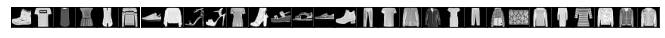

In [16]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap='gray')

このとき読み込んだ画像は(バッチサイズ、縦の画素数、 横の画素数)の次元で表されています。

In [17]:
x_train.shape

60000

In [5]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)) / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Lesson1の多層パーセプトロンでは入力を (バッチサイズ、画素数) の2次元テンソルとして扱いましたが、 CNNでは2次元の画像として処理していくために4次元テンソル (バッチサイズ、縦の画素数、横の画素数、チャンネル数)として扱います。 チャンネル数は白黒画像の場合は1、 カラー画像の場合はRGBで3です。

Fashion MNISTの画像は白黒データですので**チャンネル数を1に設定しています。(カラー画像の場合はチャンネル数が3になります)**


In [6]:
x_train.shape

(60000, 28, 28, 1)

#### 2.1.2 実装

In [18]:
model = Sequential()

# 入力画像 28x28x1 (縦の画素数)x(横の画素数)x(チャンネル数)
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal', input_shape=(28, 28, 1)))  # 28x28x1 -> 24x24x16
model.add(MaxPooling2D(pool_size=(2, 2)))  # 24x24x16 -> 12x12x16
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal'))  # 12x12x16 -> 8x8x64
model.add(MaxPooling2D(pool_size=(2, 2)))  # 8x8x64 -> 4x4x64

model.add(Flatten())  # 4x4x64-> 1024
model.add(Dense(10, activation='softmax'))  # 1024 -> 10

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

作成したモデルを確認してみましょう。

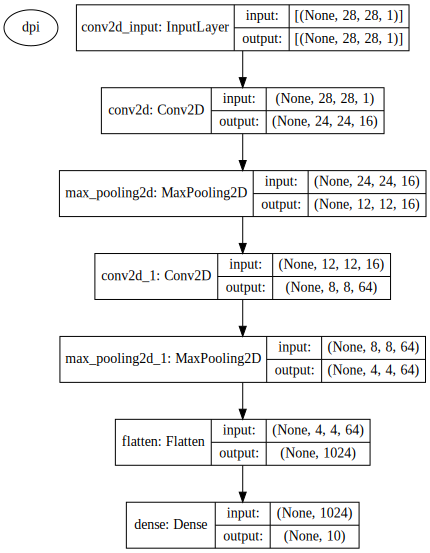

In [20]:
SVG(model_to_dot(model, show_shapes=True,dpi=None).create(prog='dot', format='svg'))

In [21]:
early_stopping = EarlyStopping(patience=1, verbose=1)
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, verbose=1,
          validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/100
469/469 [==============================] - 24s 4ms/step - loss: 0.5294 - accuracy: 0.8113 - val_loss: 0.4201 - val_accuracy: 0.8544
Epoch 2/100
469/469 [==============================] - 1s 3ms/step - loss: 0.3475 - accuracy: 0.8756 - val_loss: 0.3516 - val_accuracy: 0.8752
Epoch 3/100
469/469 [==============================] - 1s 3ms/step - loss: 0.3058 - accuracy: 0.8904 - val_loss: 0.3255 - val_accuracy: 0.8870
Epoch 4/100
469/469 [==============================] - 1s 3ms/step - loss: 0.2770 - accuracy: 0.9004 - val_loss: 0.3144 - val_accuracy: 0.8889
Epoch 5/100
469/469 [==============================] - 1s 3ms/step - loss: 0.2548 - accuracy: 0.9082 - val_loss: 0.3158 - val_accuracy: 0.8854
Epoch 00005: early stopping


### 2.2 CIFAR10のデータをCNNでクラス分類

####  2.2.1 データセットの読み込み

6万枚のカラー画像に10のカテゴリのどれかが付与されたCIFAR-10というデータセットを使用します。

まず、データを読み込みます。

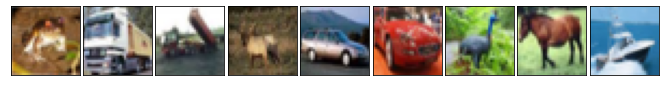

In [23]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

x_train = x_train.astype('float32') / 255
y_train = np.eye(10)[y_train.astype('int32').flatten()]

x_test = x_test.astype('float32') / 255
y_test = np.eye(10)[y_test.astype('int32').flatten()]

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=10000)

画像はRGBデータなのでFashion MNISTとは異なり、チャンネル数は3になります。

In [24]:
x_train.shape

(40000, 32, 32, 3)

次に、CIFAR-10の画像の例を表示してみます。この画像ひとつひとつに10のカテゴリのうちひとつが付与されています。

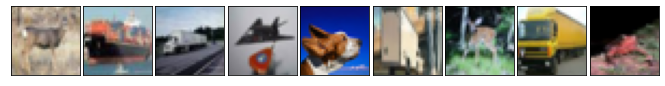

In [25]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i])

以下のネットワークを実装してみます。

![](./figures/lenet.png)

Y. LeCun et al., "Gradient-based learning applied to document recognition", Proceedings of the IEEE, 1998

#### 2.2.2 実装

In [26]:
model = Sequential()

model.add(Conv2D(6, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal', input_shape=(32, 32, 3)))  # 32x32x3 -> 28x28x6
model.add(MaxPooling2D(pool_size=(2, 2)))  # 28x28x6 -> 14x14x6
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal'))  # 14x14x6 -> 10x10x16
model.add(MaxPooling2D(pool_size=(2, 2)))  # 10x10x16 -> 5x5x16

model.add(Flatten())  # 5x5x16 -> 400
model.add(Dense(120, activation='relu',
                kernel_initializer='he_normal'))  # 400 ->120
model.add(Dense(84, activation='relu', kernel_initializer='he_normal'))  # 120 ->84
model.add(Dense(10, activation='softmax'))  # 84 ->10

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

作成したモデルを確認してみましょう。

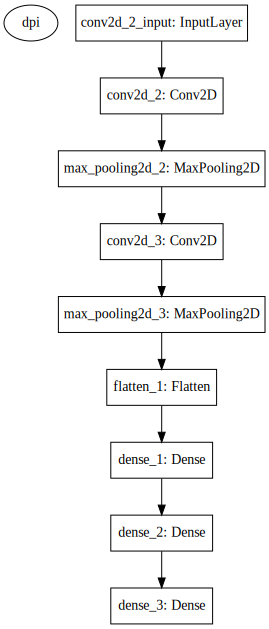

In [28]:
SVG(model_to_dot(model,dpi=None).create(prog='dot', format='svg'))

In [29]:
early_stopping = EarlyStopping(patience=1, verbose=1)
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, verbose=1,
          validation_data=(x_valid, y_valid), callbacks=[early_stopping])

Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 1.7331 - accuracy: 0.3700 - val_loss: 1.5523 - val_accuracy: 0.4379
Epoch 2/100
313/313 [==============================] - 1s 4ms/step - loss: 1.4421 - accuracy: 0.4789 - val_loss: 1.4996 - val_accuracy: 0.4550
Epoch 3/100
313/313 [==============================] - 1s 4ms/step - loss: 1.3418 - accuracy: 0.5220 - val_loss: 1.3578 - val_accuracy: 0.5183
Epoch 4/100
313/313 [==============================] - 1s 4ms/step - loss: 1.2757 - accuracy: 0.5447 - val_loss: 1.2957 - val_accuracy: 0.5379
Epoch 5/100
313/313 [==============================] - 1s 4ms/step - loss: 1.2260 - accuracy: 0.5644 - val_loss: 1.2570 - val_accuracy: 0.5523
Epoch 6/100
313/313 [==============================] - 1s 4ms/step - loss: 1.1828 - accuracy: 0.5778 - val_loss: 1.2811 - val_accuracy: 0.5488
Epoch 00006: early stopping
